# Chapter 11: The Landscape

For additional context see Chapter 11 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr
from process_improvement import comparison_charts as cc
from process_improvement import network_analysis as na

%matplotlib inline

## Get the data

The dataset used in this chapter is called:

`shewharts-resistance-measurements.csv`

The dataset can be found at https://github.com/jimlehner/the-virus-of-variation/tree/main/data.

In [2]:
# Dataset url
dataset_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/shewharts-resistance-measurements.csv'

# Get data
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
resistance_df = get_data()

# Make 'Year' column dtype string
resistance_df['Value'] = resistance_df['Value'].astype('string')

# Drop 'Units' column
resistance_df = resistance_df.drop('Units', axis=1)

# Show df
resistance_df.head()

,Stage,Value,Resistance
0,Initial,1,5045
1,Initial,2,4350
2,Initial,3,4350
3,Initial,4,3975
4,Initial,5,4290


In [3]:
# Split resistance_df by stage
initial_df = resistance_df[resistance_df['Stage'] == 'Initial'].copy()

# Calculate the moving range for the initial_df
initial_df['Moving Range'] = abs(initial_df['Resistance'].diff())

# Create additional dataframe
additional_df = resistance_df[resistance_df['Stage'] == 'Additional'].reset_index(drop=True)

# Calculate the moving range for the additional_df
additional_df['Moving Range'] = abs(additional_df['Resistance'].diff())

additional_df

,Stage,Value,Resistance,Moving Range
0,Additional,1,4400,NaN
1,Additional,2,4565,165.0
2,Additional,3,4495,70.0
3,Additional,4,4325,170.0
4,Additional,5,4385,60.0
...,...,...,...,...
59,Additional,60,4565,25.0
60,Additional,61,4210,355.0
61,Additional,62,4540,330.0
62,Additional,63,4600,60.0


## Figure 11.1: XmR chart of initial resistance measurements

In [4]:
# Specify round_value
round_value = 1

# Extract Data
data = initial_df['Resistance']
labels = initial_df['Value']

moving_range = initial_df['Moving Range'].copy()
moving_range.iloc[0] = np.nan

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_range.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(max(0,mean - (C1*average_mR)))

if LPL != 0:
    LPL = round(LPL, round_value)

# Calculate the Upper Range Limit
URL = round(C2*average_mR, round_value)

In [5]:
# Define Process Limits
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_range <= URL, moving_range)

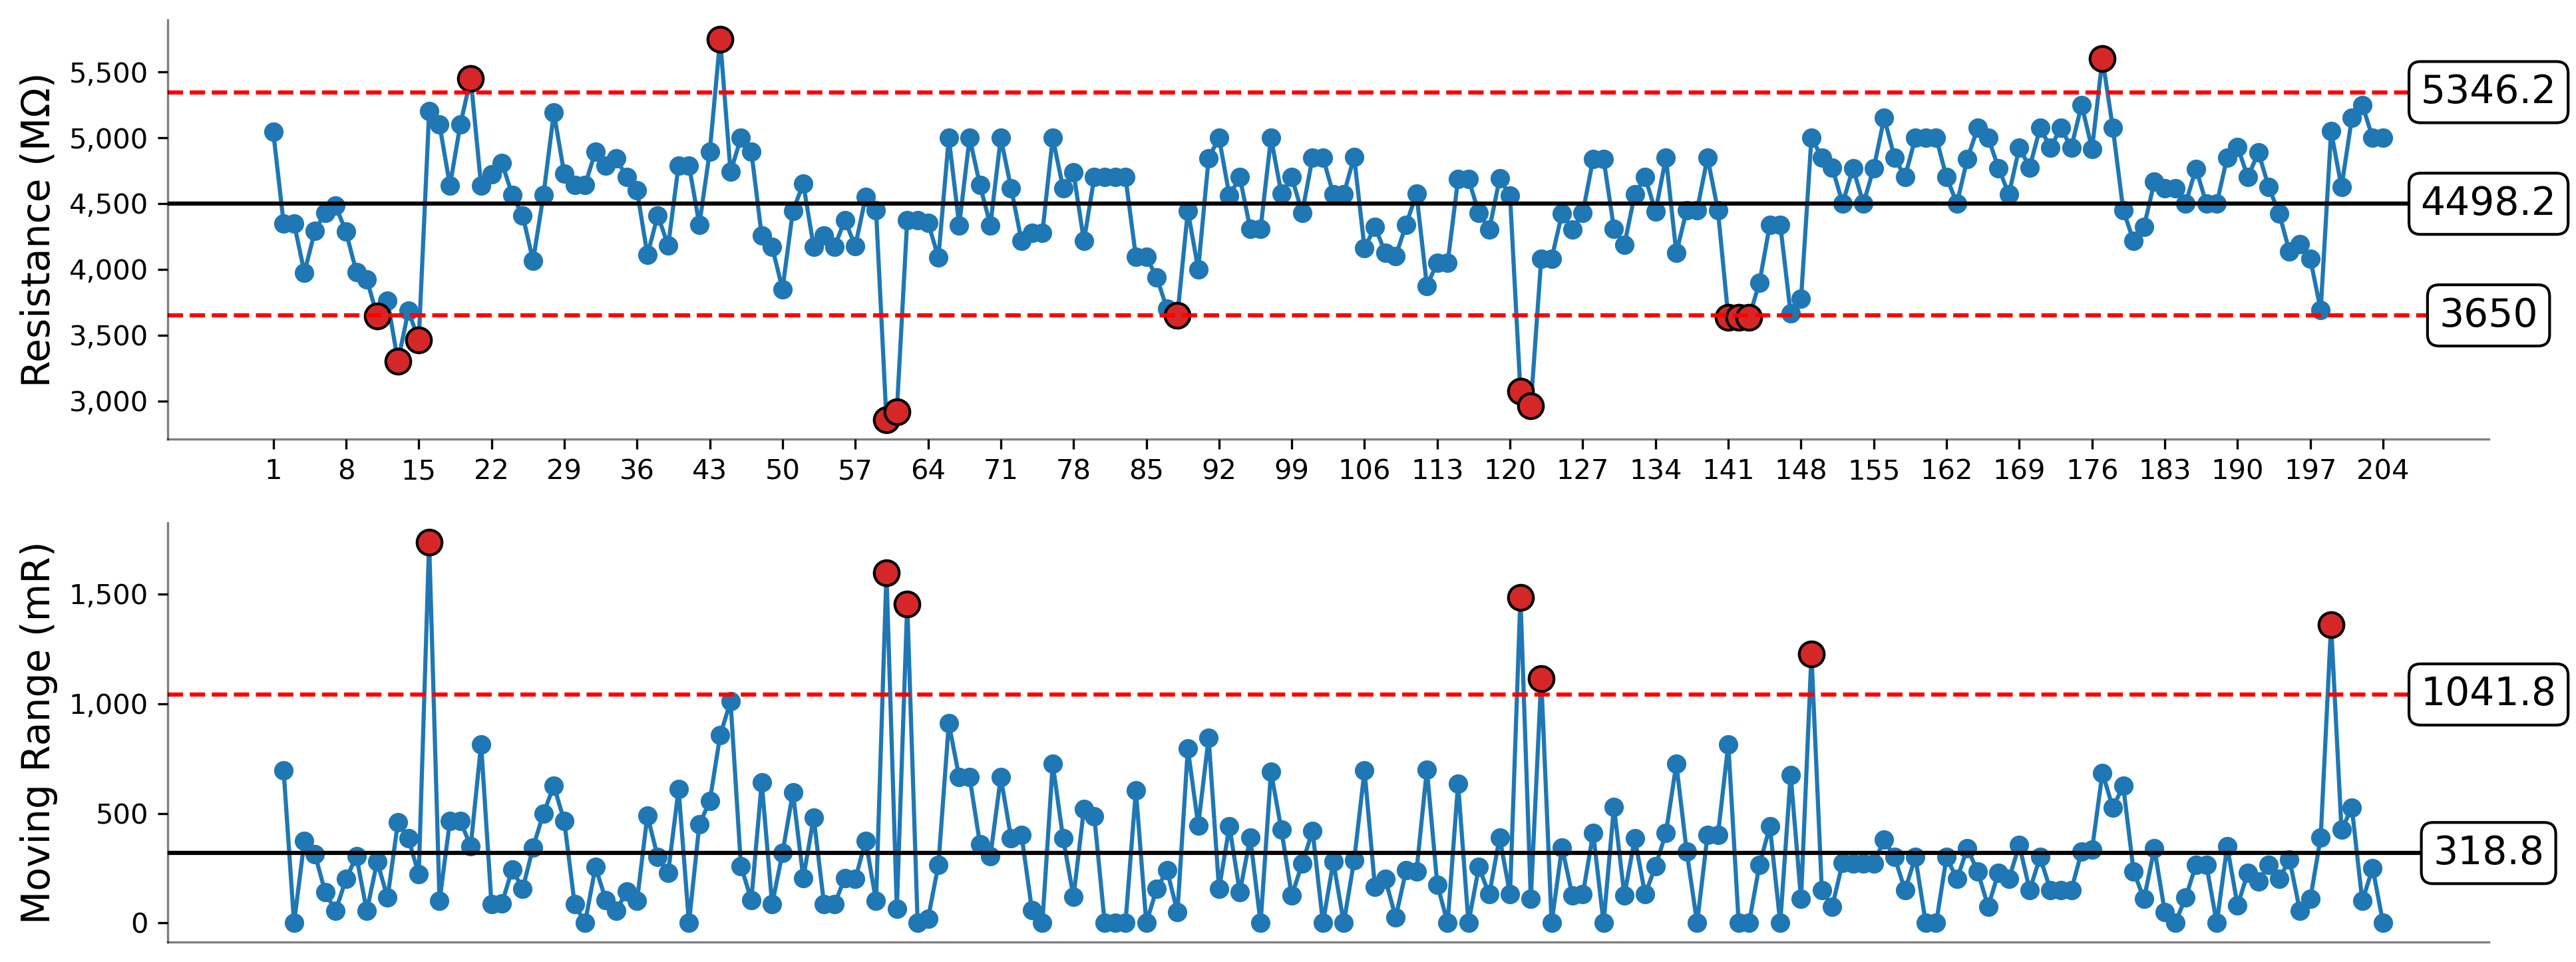

In [6]:
# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), 
                        nrows=2, 
                        ncols=1, 
                        dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, linetype, color in xchart_lines:
    axs[0].axhline(value, ls=linetype, c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value, round_value),
                color='black', ha='center', va='center', 
                fontsize=14, bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_range, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Offset moving range by 1 relative to the individual values
for xi, yi in zip(labels, moving_range):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0)

# Add Process Limits
for value, linetype, color in mrchart_lines:
    axs[1].axhline(value, ls=linetype, c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1], value, round(value, round_value),
                color='black', ha='center', va='center', 
                fontsize=14, bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel('Resistance (MΩ)', fontsize=14)
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

for val in range(0,2):
    axs[val].yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: f'{int(y):,}' if y >= 1000 else f'{int(y)}'
    ))

# Show Plot
plt.show()

## Figure 11.2: Average and range chart of initial resistance measurements

In [7]:
# Calculate the subgroup means
initial_subgrouped = (initial_df['Resistance']
                      .groupby(initial_df.index // 4)
                      .mean()
                      .to_frame()
                      .rename(columns={'Resistance':'Subgroup Mean'})
                     )
initial_subgrouped.head()

,Subgroup Mean
0,4430.00
1,4372.50
2,3827.50
3,3912.00
4,5071.25


In [8]:
# Calculate the subgroup ranges
initial_subgrouped['Subgroup Range'] = (initial_df['Resistance']
                                    .groupby(initial_df.index // 4)
                                    .agg(lambda x: x.max() - x.min()))
# Add a 'Subgroups' column to subgroup dataframes
initial_subgrouped['Subgroup'] = (pd.Series(np.arange(1, len(initial_subgrouped)+1))
                                   .astype('string'))
initial_subgrouped.head()

,Subgroup Mean,Subgroup Range,Subgroup
0,4430.00,1070,1
1,4372.50,200,2
2,3827.50,335,3
3,3912.00,1900,4
4,5071.25,815,5


In [9]:
# Specify round_value
round_value = 1

# Calculate the grand average (average of the subgroup averages)
grand_ave = round(initial_subgrouped['Subgroup Mean'].mean(),round_value)

# Calculate the average range (average of the subgroup ranges)
ave_range = round(initial_subgrouped['Subgroup Range'].mean(),round_value)

print('Grand Ave:', grand_ave)
print('Average Range:', ave_range)

Grand Ave: 4498.2
Average Range: 658.6


In [10]:
# Calculate the process limits for the average and range chart
# Specify A2 for subgroup size n=4
A2 = 0.729
# Specify D3 and D4 for subgroups of size n=4
D3 = -0.282
D4 = 2.282

# Calculate the Average Chart limits
UAL = round(grand_ave + (A2*ave_range),round_value)
LAL = round(grand_ave - (A2*ave_range),round_value)

# Calculate the Range Chart limits
range_URL = round(D4*ave_range,round_value)
range_LRL = max(0, round(D3*ave_range))

# Print results
print("Upper Average Limit:", UAL)
print("Lower Average Limit:", LAL)
print("Upper Range Limit:", range_URL)
print("Lower Range Limit:", range_LRL)

Upper Average Limit: 4978.3
Lower Average Limit: 4018.1
Upper Range Limit: 1502.9
Lower Range Limit: 0


In [11]:
# Build the average and range chart elements
data = initial_subgrouped['Subgroup Mean']
labels = initial_subgrouped['Subgroup']
moving_ranges = initial_subgrouped['Subgroup Range']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UAL, data)
lower_lim = np.ma.masked_where(data > LAL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= range_URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > range_LRL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
average_chart_lines = [(grand_ave, '-', 'black'), (UAL, '--', 'red'), (LAL, '--', 'red')]
range_chart_lines = [(ave_range, '-', 'black'), (range_URL, '--', 'red'), (range_LRL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
average_chart_labels = [(UAL,UAL),(LAL,LAL),(grand_ave,grand_ave)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
range_chart_labels = [(range_URL,range_URL),(ave_range,ave_range)]

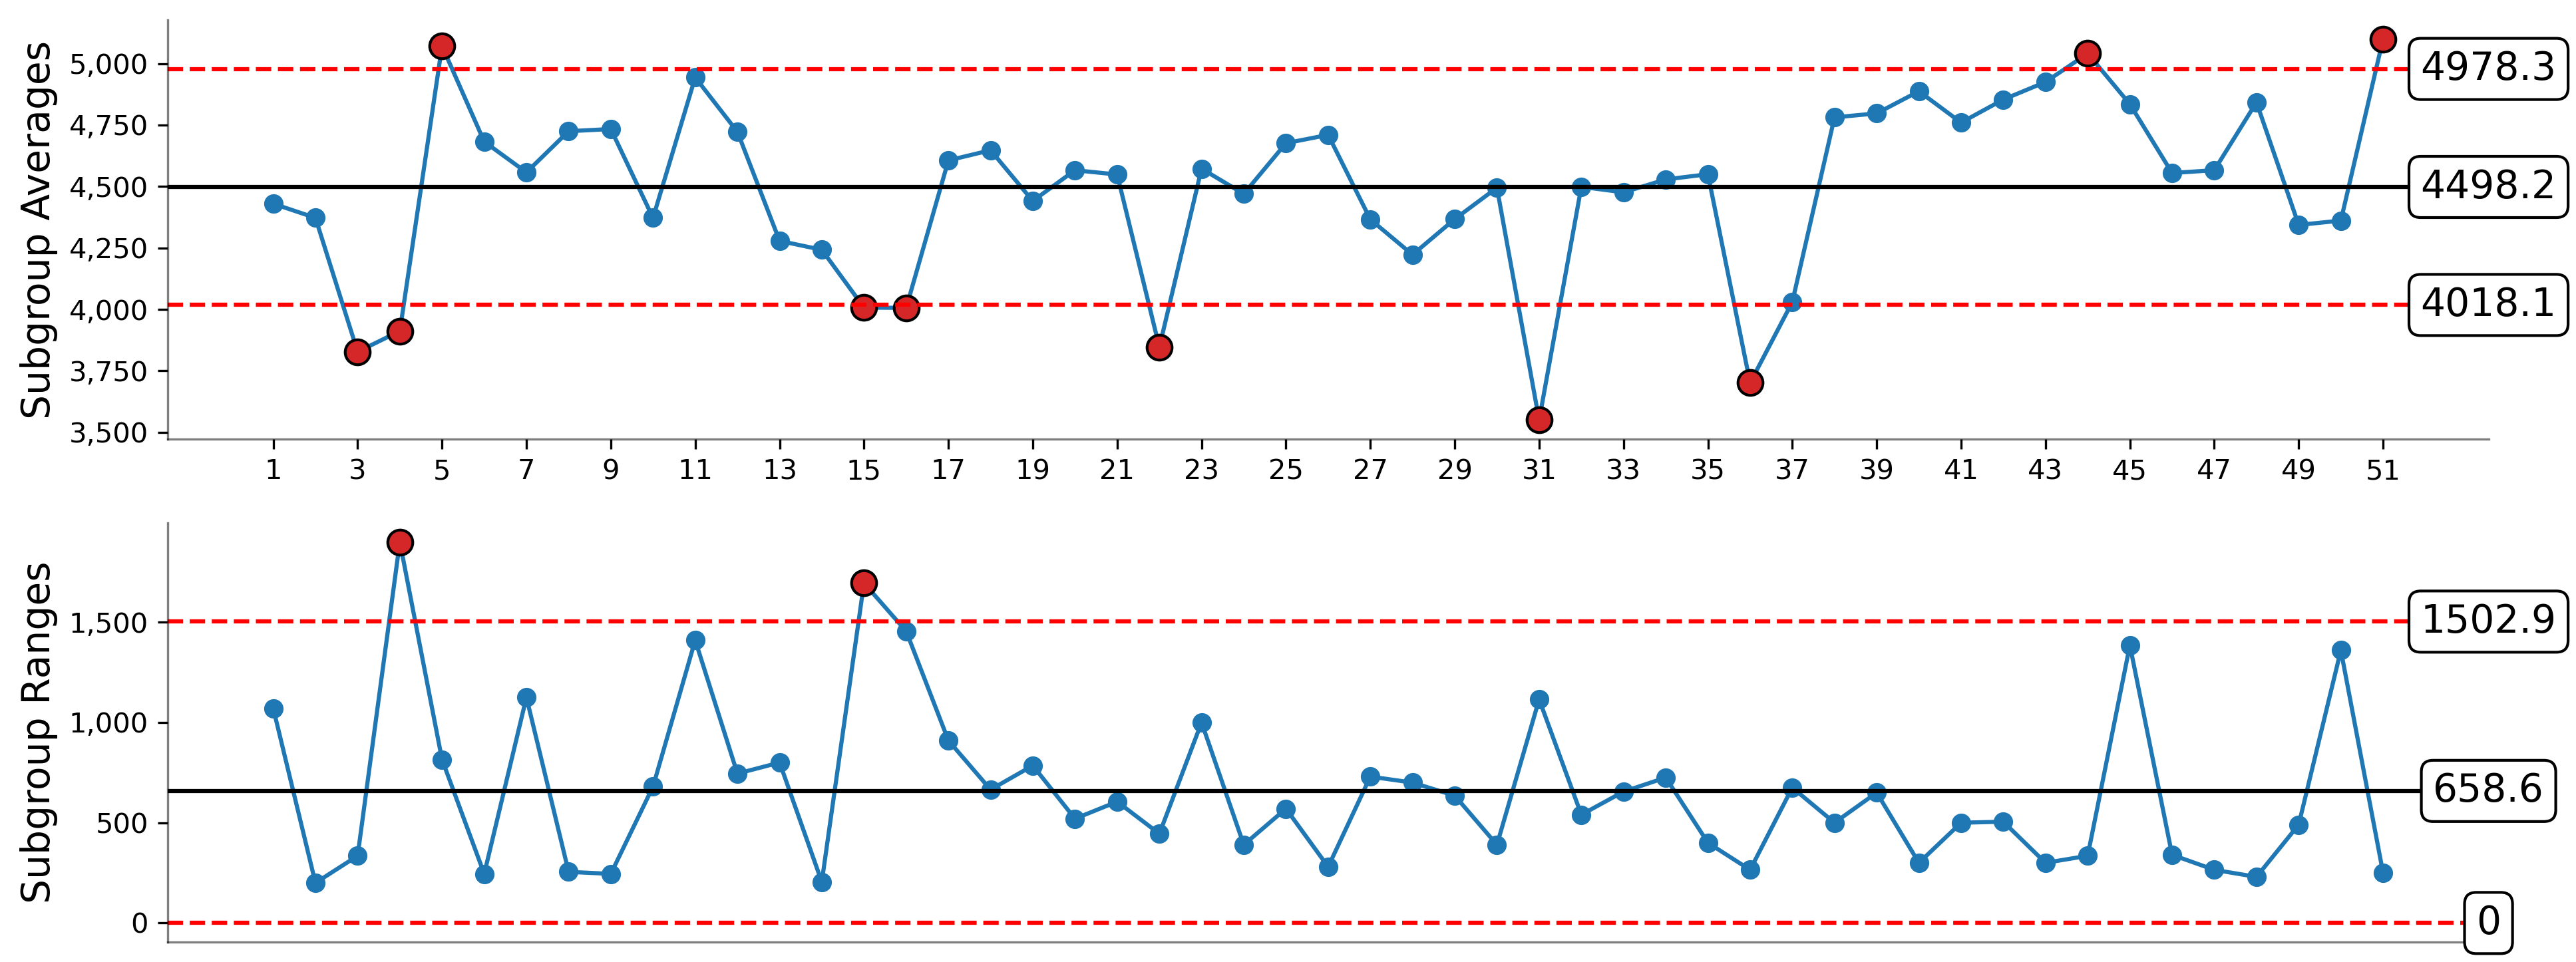

In [12]:
# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

for val in [UAL, LAL, grand_ave]:
    axs[0].text(axs[0].get_xlim()[1], val, val, color='black', ha='center', va='center', 
                fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linetype, color in average_chart_lines:
    axs[0].axhline(value, ls=linetype, c=color)
    
# Plot subgroup ranges on range chart
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[1].plot(labels, url_less, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

for val in [range_URL, range_LRL, ave_range]:
    axs[1].text(axs[1].get_xlim()[1], val, val, color='black', ha='center', va='center',
                fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linetype, color in range_chart_lines:
    axs[1].axhline(value, ls=linetype, c=color)

# # Set the x-tick labels with increased intervals
tick_interval = 2  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Subgroup Averages", fontsize=14)

axs[1].set_xlabel("",fontsize=12)
axs[1].set_ylabel("Subgroup Ranges", fontsize=14)

axs[1].set_xticks([])

# Despine
sns.despine()
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Set titles
# axs[0].set_title("Average and Range Chart of Resistance Measurements", 
#                  fontsize=16)

for val in range(0,2):
    axs[val].yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: f'{int(y):,}' if y >= 1000 else f'{int(y)}'
    ))

# Show plot
plt.show()

## Figure 11.3: Comparison of X chart and Average chart

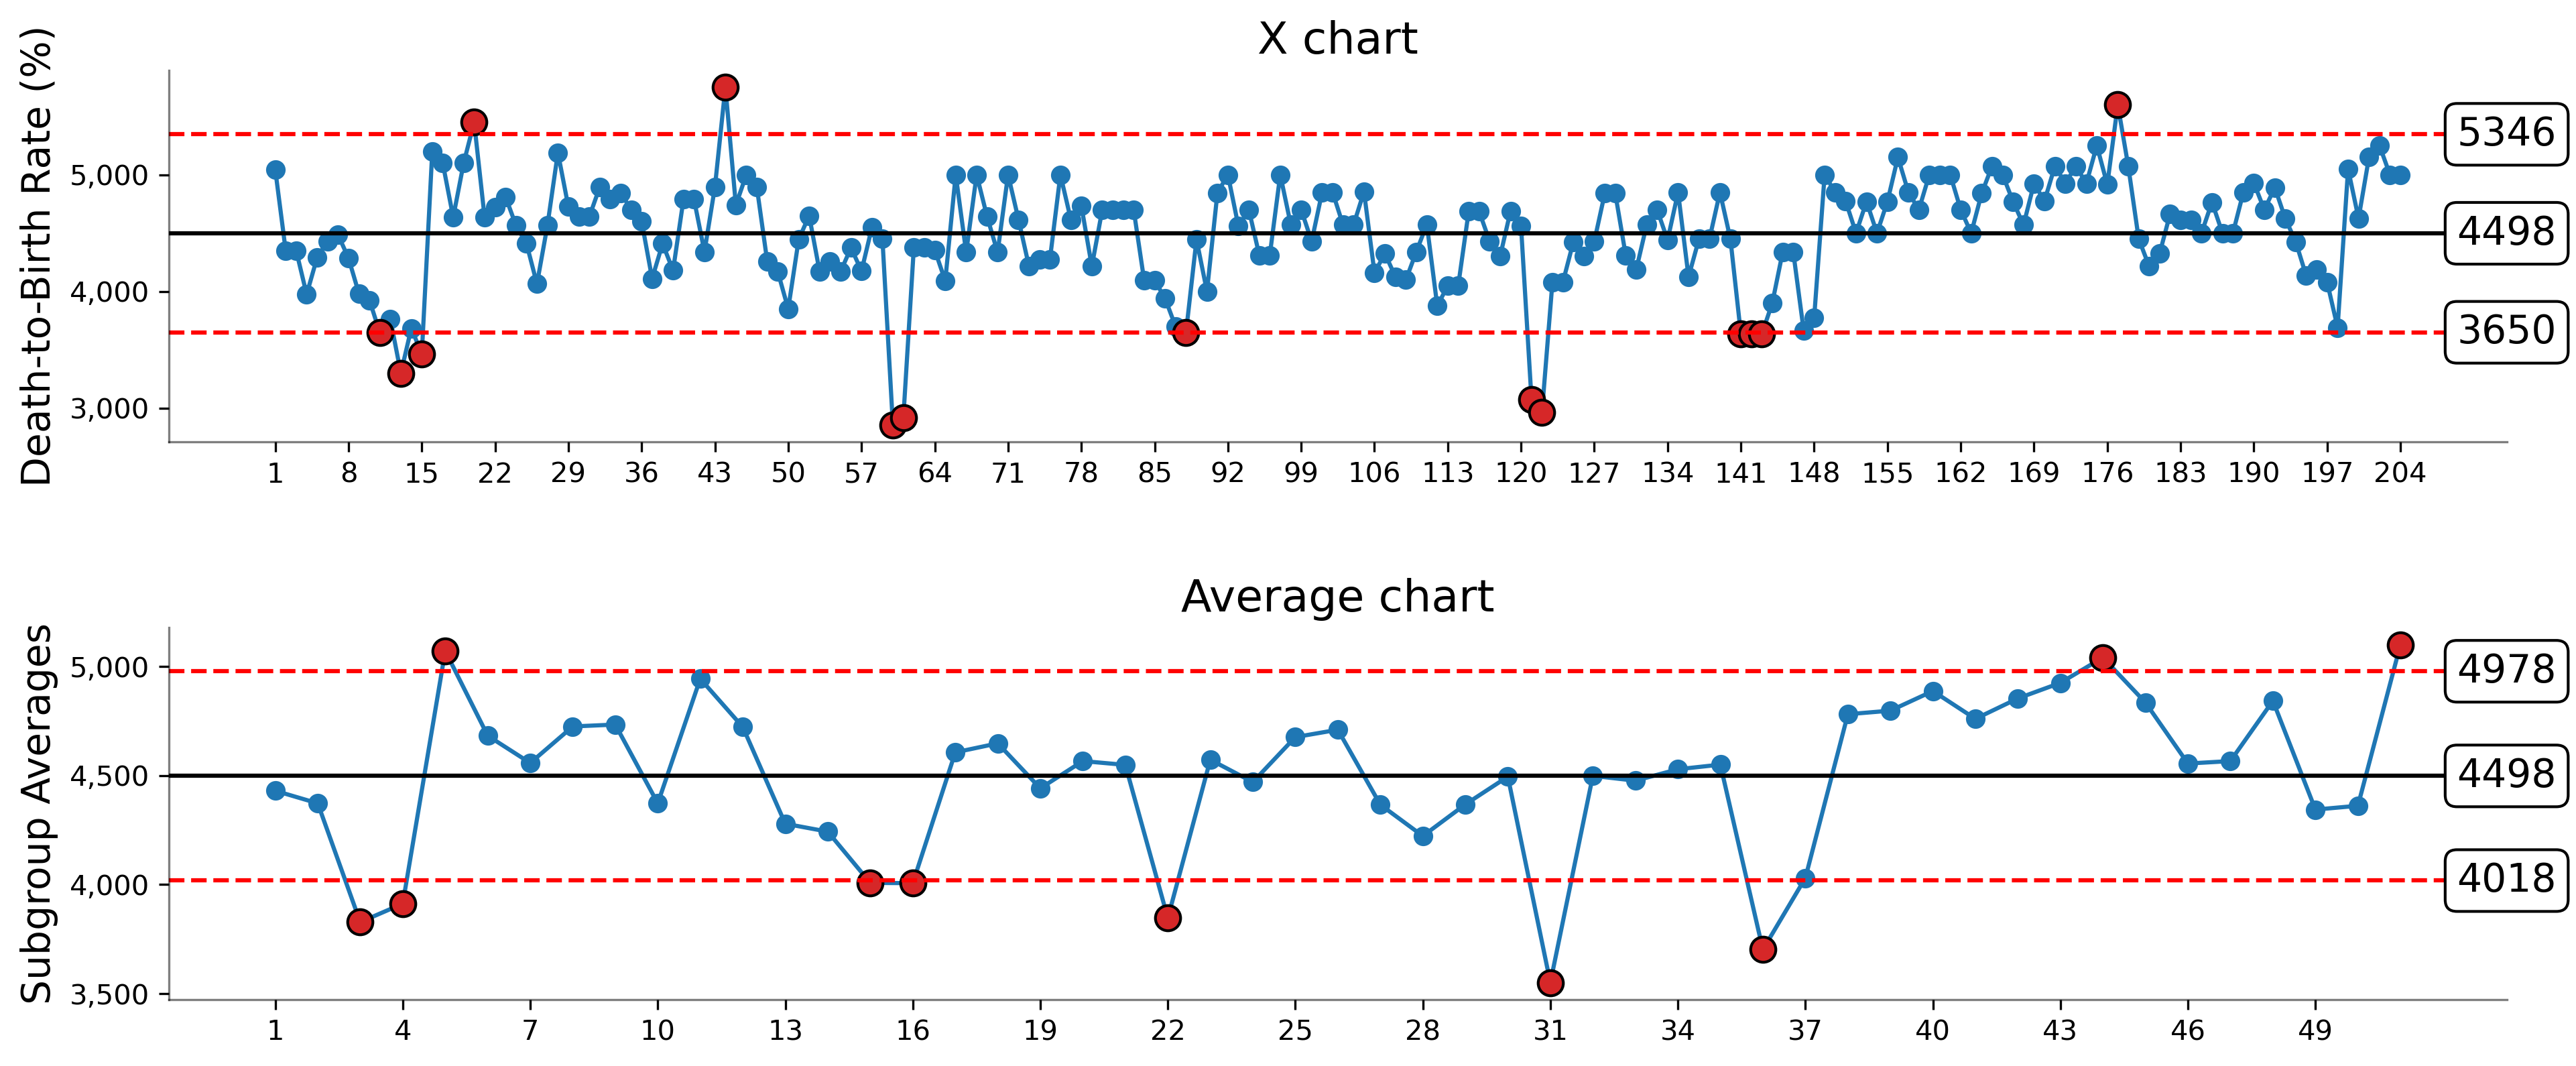

In [13]:
# Specify tickinterval
tick_interval_1 = 7
tick_interval_2 = 3
round_value=2

# Disaggregate the dataframe 
data = initial_df["Resistance"]
labels = initial_df["Value"]

subgrouped_data = initial_subgrouped['Subgroup Mean']
subgrouped_labels = initial_subgrouped['Subgroup']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than and less than the process limits on X-chart
subgrouped_upper_lim = np.ma.masked_where(subgrouped_data < UAL, subgrouped_data)
subgrouped_lower_lim = np.ma.masked_where(subgrouped_data > LAL, subgrouped_data)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL,'--', 'red'), (LPL, '--', 'red')]
average_chart_lines = [(grand_ave, '-', 'Black'),(LAL, '--', 'red'),(UAL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
average_chart_labels = [(UAL),(LAL),(grand_ave,grand_ave)]

# Generate the X-chart
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,6), dpi=300)#, sharey=True)
plt.subplots_adjust(hspace=0.5)

# Plot X Chart data
ax1.plot(labels, data, marker='o')
# Plot Average Chart data
ax2.plot(subgrouped_labels, subgrouped_data, marker='o')

# Add masking parameters to color values outside process limits
ax1.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax1.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add masking parameters for Average chart
ax2.plot(subgrouped_labels, subgrouped_lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax2.plot(subgrouped_labels, subgrouped_upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for val in [UPL, LPL, mean]:
    ax1.text(ax1.get_xlim()[1], val, round(val), color='black', ha='center', va='center',
             fontsize=14, bbox=bbox_props)
for val in [UAL, LAL, grand_ave]:
    ax2.text(ax2.get_xlim()[1], val, round(val), color='black', ha='center', va='center',
             fontsize=14, bbox=bbox_props)

# Add centerline and limits to X Chart
for value, linetype, color in xchart_lines:
    ax1.axhline(value, ls=linetype, c=color)
# Add centerline and limits to Average Chart
for value, linetype, color in average_chart_lines:
    ax2.axhline(value, ls=linetype, c=color)

# Specify spine visibility 
sns.despine()

# # Set the x-tick labels with increased intervals
tick_positions_1 = np.arange(0, len(labels), tick_interval_1)
tick_positions_2 = np.arange(0, len(subgrouped_labels), tick_interval_2)

# Set xticks for X Chart
ax1.set_xticks(tick_positions_1)
ax1.set_xticklabels(labels.iloc[tick_positions_1], rotation=0, ha='center') 
# Set xticks for Average Chart
ax2.set_xticks(tick_positions_2)
ax2.set_xticklabels(subgrouped_labels.iloc[tick_positions_2], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
ax1.set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
ax2.set_ylabel("Subgroup Averages", fontsize=14)

# Set titles
ax1.set_title("X chart", fontsize=16)
ax2.set_title("Average chart", fontsize=16)

# Set alpha for spines
for ax in (ax1, ax2):
    ax.spines[['left','bottom']].set_alpha(0.5)
    ax.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: f'{int(y):,}' if y >= 1000 else f'{int(y)}'
    ))

# Show plot
plt.show()

## Figure 11.4: Comparison of mR chart and range chart

In [14]:
# Calculate the Upper Range Limit
URL = round(C2*average_mR,2)

# Specify D3 and D4 for subgroups of size n=4
D3 = -0.282
D4 = 2.282
# Calculate the Range Chart limits
range_URL = round(D4*ave_range)
range_LRL = max(0, round(D3*ave_range))

In [15]:
# Specify tickinterval
tickinterval = 10

# Disaggregate the dataframe 
data = initial_df["Resistance"]
moving_ranges = initial_df['Moving Range']
labels = initial_df["Value"]

subgrouped_ranges = initial_subgrouped['Subgroup Range']
subgrouped_labels = initial_subgrouped['Subgroup']

# Define line parameters
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]
# Mask values outside limits
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UAL, data)
lower_lim = np.ma.masked_where(data > LAL, data)
# Create masking parameters for values greater than URL on mR-chart
subgrouped_url_greater = np.ma.masked_where(subgrouped_ranges <= range_URL, subgrouped_ranges)
subgrouped_url_less = np.ma.masked_where(subgrouped_ranges > range_LRL, subgrouped_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
range_chart_lines = [(ave_range, '-', 'black'), (range_URL, '--', 'red'), (range_LRL, '--', 'red')]
range_chart_labels = [(range_URL,range_URL),(ave_range,ave_range)]

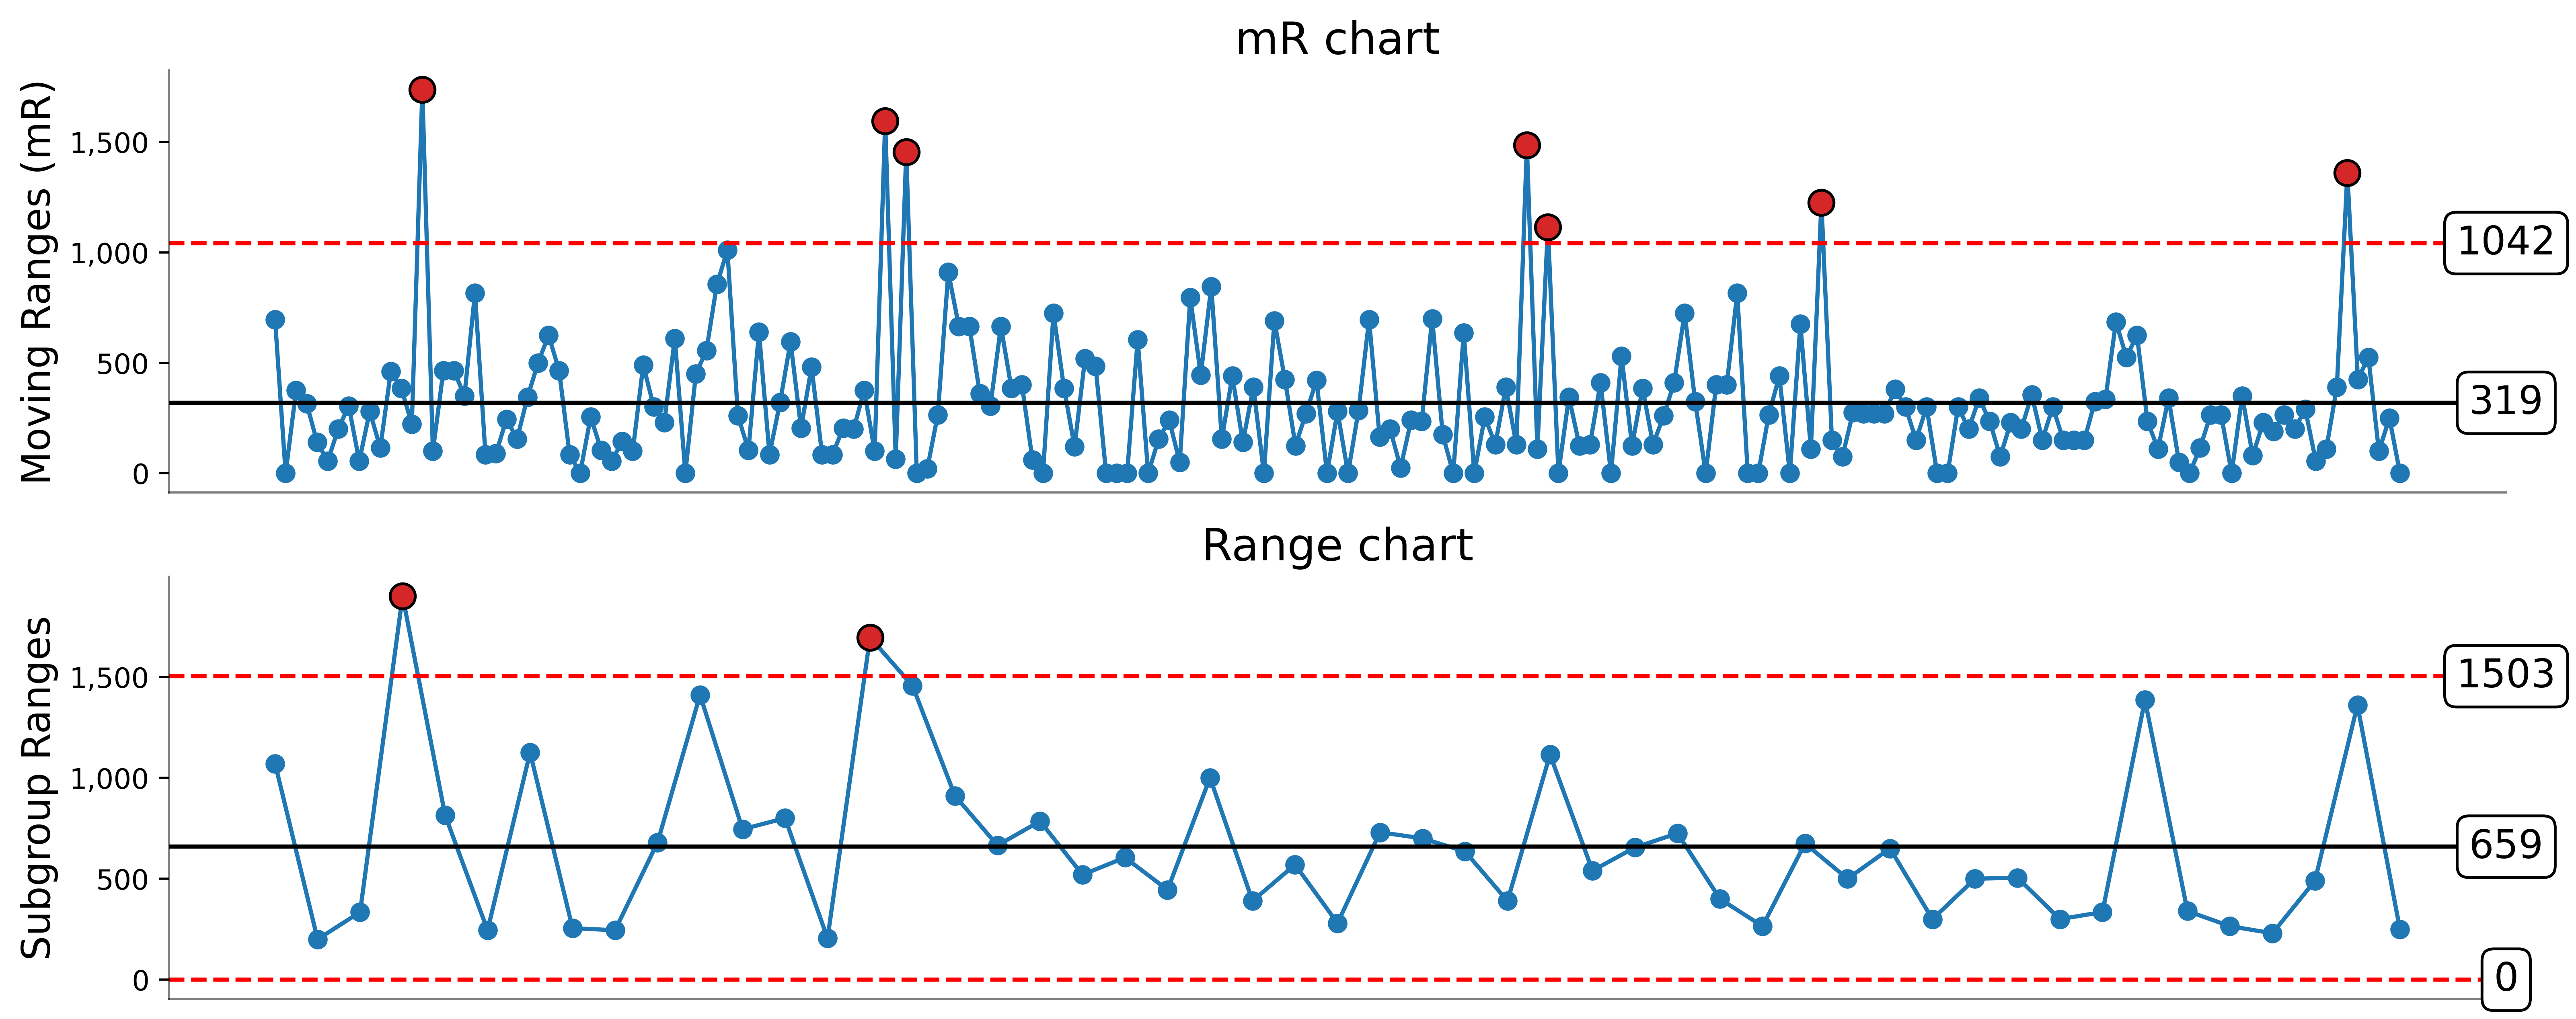

In [16]:
# Create figure and axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6), dpi=500)

# Moving Range Chart (mR Chart)
axs[0].plot(labels, moving_ranges, marker='o')
# Masking parameters mR Chart
axs[0].plot(labels, url_greater, marker='o', ls='none', 
            color='tab:red', markeredgecolor='black', markersize=9)
# Masking paramters for Range Chart
axs[1].plot(subgrouped_labels, subgrouped_ranges, marker='o')
axs[1].plot(subgrouped_labels, subgrouped_url_greater, marker='o', 
            color='tab:red', markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for val in [URL, URL, average_mR]:
    axs[0].text(axs[0].get_xlim()[1], val, round(val), color='black', ha='center', va='center',
                fontsize=14, bbox=bbox_props)
for val in [range_URL, range_LRL, ave_range]:
    axs[1].text(axs[1].get_xlim()[1], val, round(val), color='black', ha='center', va='center',
                fontsize=14, bbox=bbox_props)

# Add centerline and limits to X Chart
for value, linetype, color in mrchart_lines:
    axs[0].axhline(value, ls=linetype, c=color)
# Add centerline and limits to Average Chart
for value, linetype, color in range_chart_lines:
    axs[1].axhline(value, ls=linetype, c=color)

# Despine
sns.despine()
# Remove xticks and yticks for both plots
for val in range(0,2):
    axs[val].set_xticks([])
#     axs[val].set_yticks([])
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Set titles
axs[0].set_title("mR chart", fontsize=16)
axs[1].set_title("Range chart", fontsize=16)

# Specify axis labels and title
plt.xlabel("",fontsize=12)
axs[0].set_ylabel("Moving Ranges (mR)", fontsize=14)
axs[1].set_ylabel("Subgroup Ranges", fontsize=14)

for val in range(0,2):
    axs[val].yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: f'{int(y):,}' if y >= 1000 else f'{int(y)}'
    ))

# Show plot
plt.show()

## Figure 11.5: XmR chart calculated using the median moving range

In [17]:
# Specify round_value
round_value = 1

# Calculate mean of resistance measurements
mean = round(initial_df['Resistance'].mean(),round_value)

# Calculate average moving range
median_mR = round(initial_df['Moving Range'].median(),round_value)

# Set values for the numeric constants C1 and C2
E5 = 3.145
D6 = 3.865

# Calculate the Upper Range Limit
UPL = round(mean + (E5*median_mR),round_value)
# Calculate the Lower Process Limit
LPL = round(max(0, mean - (E5*median_mR))) # Note the max condition 
# Calculate the Upper Range Limit
URL = round(D6*median_mR,round_value)

# Show the results 
print('UPL:',UPL, 'LPL:',LPL,'URL:',URL)

UPL: 5315.9 LPL: 3680 URL: 1004.9


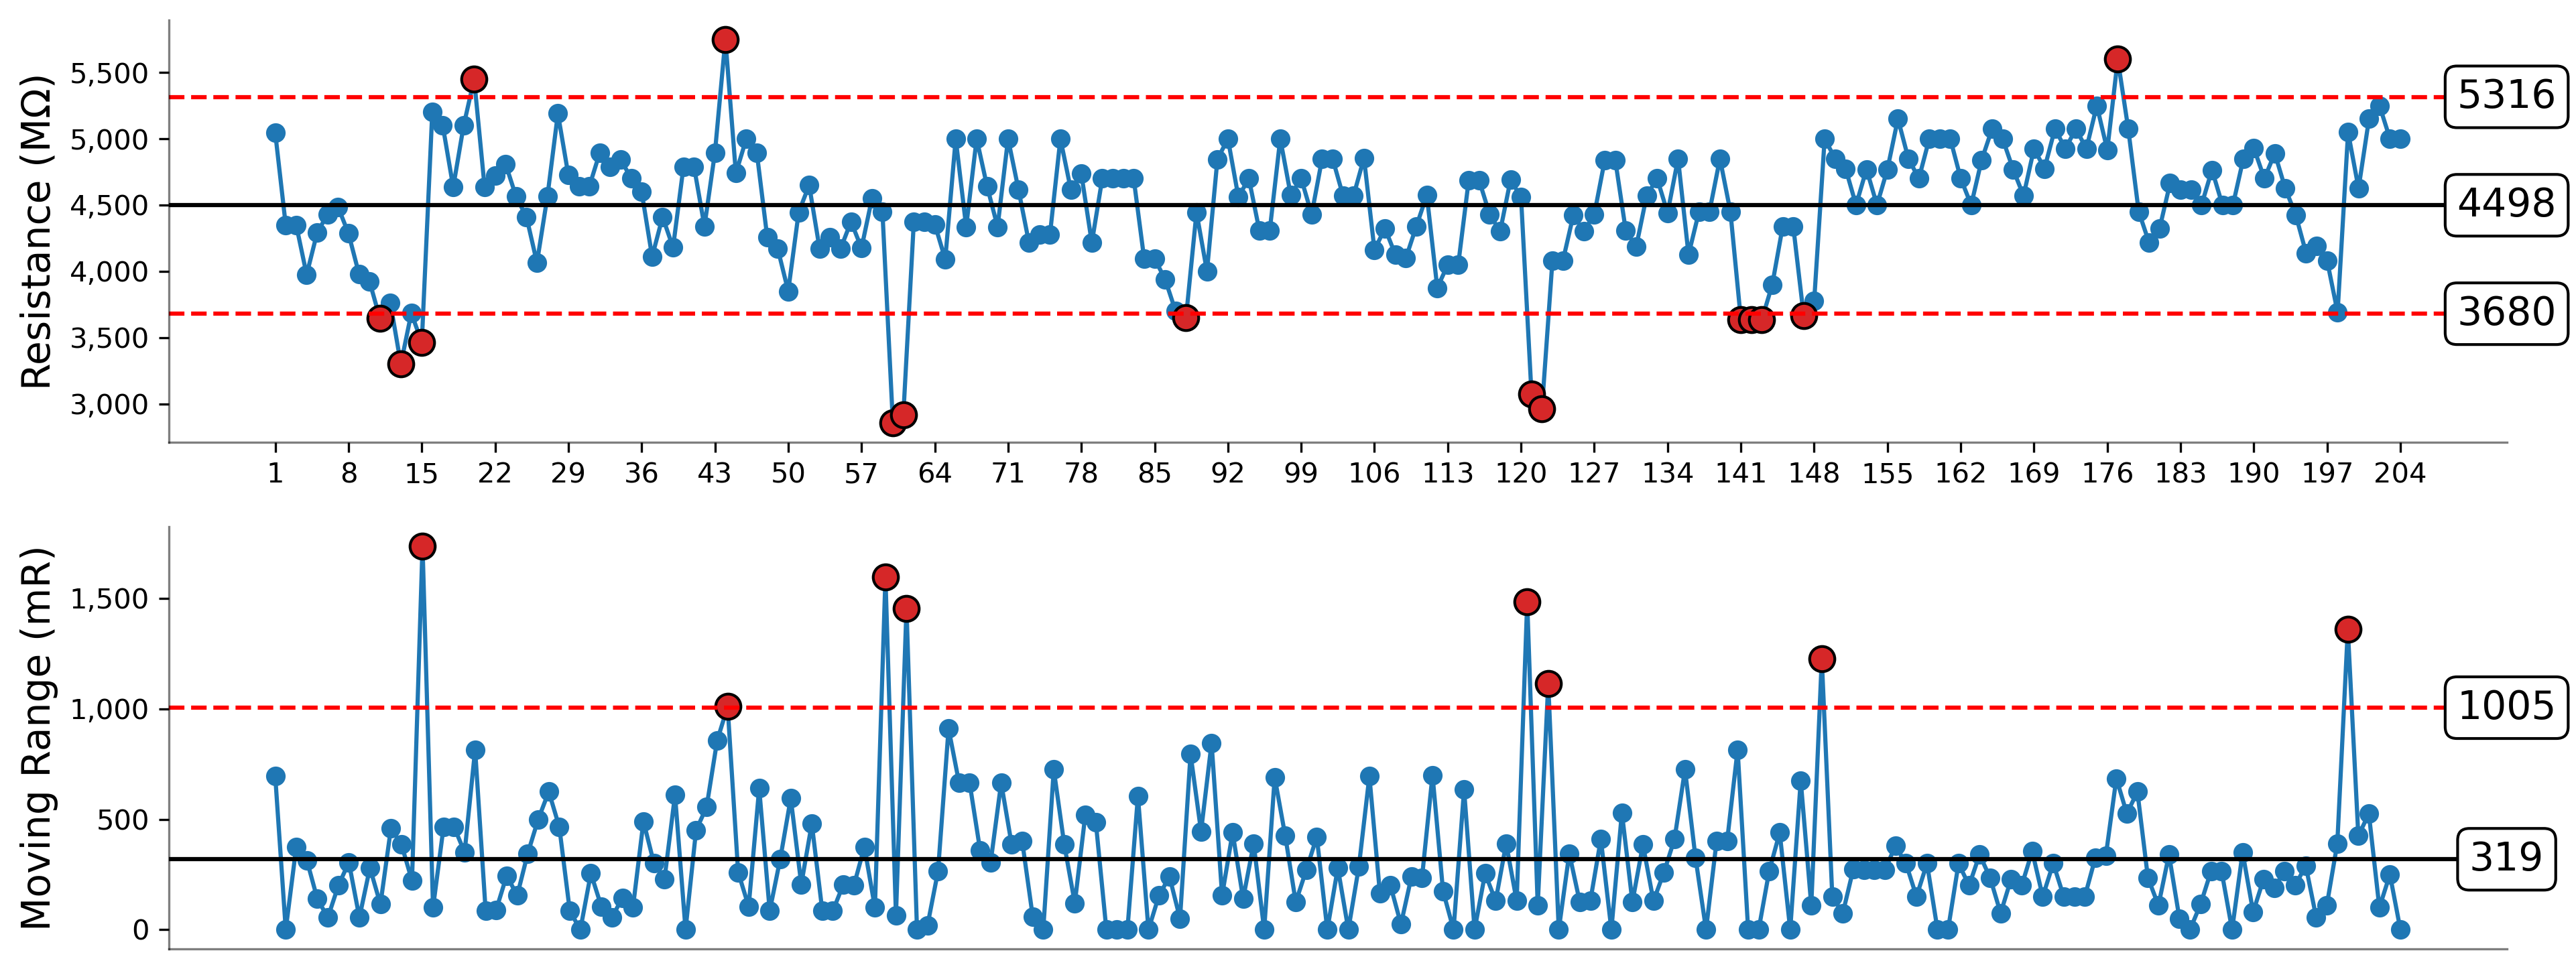

In [18]:
# Extract Data
data = initial_df['Resistance']
labels = initial_df['Value']
moving_ranges = initial_df['Moving Range']

# Define Process Limits
xchart_lines = [(mean, 'black', '-'), (UPL, 'red', '--'), (LPL, 'red', '--')]
mrchart_lines = [(average_mR, 'black', '-'), (URL, 'red', '--')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), 
                        nrows=2, 
                        ncols=1, 
                        dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color, linetype in xchart_lines:
    axs[0].axhline(value, ls=linetype, c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value), fontsize=14,
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color, linetype in mrchart_lines:
    axs[1].axhline(value, ls=linetype, c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1], value, round(value), fontsize=14,
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Resistance (MΩ)", fontsize=14)
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

for val in range(0,2):
    axs[val].yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: f'{int(y):,}' if y >= 1000 else f'{int(y)}'
    ))

# Show Plot
plt.show()